Dựa trên bộ dữ liệu về nhà ở California, dưới đây là mô tả các bước để giải quyết bài toán từ thu thập dữ liệu đến ứng dụng mô hình.

# Bước 1: Define the problem

Bài toán ở đây là dự đoán giá nhà trung bình tại các khu vực khác nhau ở California. Mục tiêu là phát triển một mô hình học máy có thể dự đoán giá nhà dựa trên các đặc điểm của khu vực như thu nhập trung bình, tuổi của ngôi nhà, số lượng phòng, và các yếu tố khác. Dự đoán này có thể giúp các nhà đầu tư bất động sản, các cơ quan chính phủ và cá nhân có cái nhìn sâu sắc hơn về thị trường nhà ở.

# Bước 2: Build the dataset

#### Khai báo các thư viện

In [1]:
# NẾU KHÔNG THẤY FOLIUM THÌ MỞ 2 COMMENT DƯỚI
# import sys
# !{sys.executable} -m pip install folium
import folium
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
import urllib.request
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.neighbors import KDTree
import warnings

# import sys
# !{sys.executable} -m pip install shapely
from shapely.geometry import shape, Point

#### Lọc cảnh báo

In [2]:
warnings.filterwarnings("ignore")

#### Đọc dữ liệu

In [3]:
# Load dữ liệu
california_housing = fetch_california_housing()
X = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
y = pd.DataFrame(california_housing.target, columns=["target"])
data = pd.concat([X, y], axis=1)

# # Đọc file CSV chứa thông tin về các thành phố
# cities_df = pd.read_csv('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/cal_cities_lat_long.csv')

# cities_df_2 = pd.read_csv('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/cal_populations_city.csv')

with urllib.request.urlopen('https://raw.githubusercontent.com/lahongloc/HousePricePrediction/kiet/california.png') as url:
    img = PIL.Image.open(url)
    california_img = np.array(img)
    
# Lấy HTML từ trang web
url = 'https://vi.wikipedia.org/wiki/Danh_s%C3%A1ch_%C4%91%C3%B4_th%E1%BB%8B_t%E1%BA%A1i_California'
html_data = requests.get(url).text

# Đọc các bảng từ HTML
tables = pd.read_html(html_data, header=1)

# Nếu biết bảng cần lấy nằm ở vị trí nào, ví dụ bảng thứ nhất (index 0)
cities_table = pd.DataFrame(tables[1])

#### Mô tả dữ liệu

In [4]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
data.head(50)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [6]:
data.shape

(20640, 9)

In [7]:
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Phân tích các đặc trưng:
- AveOccup (số người trung bình trên phòng): Đặc trưng này có độ lệch chuẩn rất cao (10.386) so với giá trị trung bình (3.070655), cho thấy có sự phân bố rất rộng và có thể có một số giá trị ngoại lệ cực đoan. Nên xem xét việc xử lý các giá trị ngoại lệ này để mô hình có thể học tốt hơn.
- Population (dân số): Tương tự như AveOccup, có độ lệch chuẩn cao và giá trị max (35682) xa so với 75% quantile (1725), chỉ ra sự tồn tại của outliers.
- Longitude và Latitude: Có thể cân nhắc tạo các biến phái sinh từ đặc trưng này để mô hình hoá mối quan hệ không tuyến tính giữa vị trí địa lý và giá nhà, chẳng hạn như khoảng cách đến trung tâm thành phố hoặc các địa điểm quan trọng khác.
- MedInc (thu nhập trung bình): Là đặc trưng quan trọng nhưng có phạm vi rộng (0.4999 đến 15.0001).

Đề xuất cải tiến:
=> Feature engineering: Tạo thêm features (Region) từ Longitude và Latitude có thể giúp mô hình nắm bắt tốt hơn mối quan hệ không gian.

In [8]:
data.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


#### Trực quan hóa dữ liệu

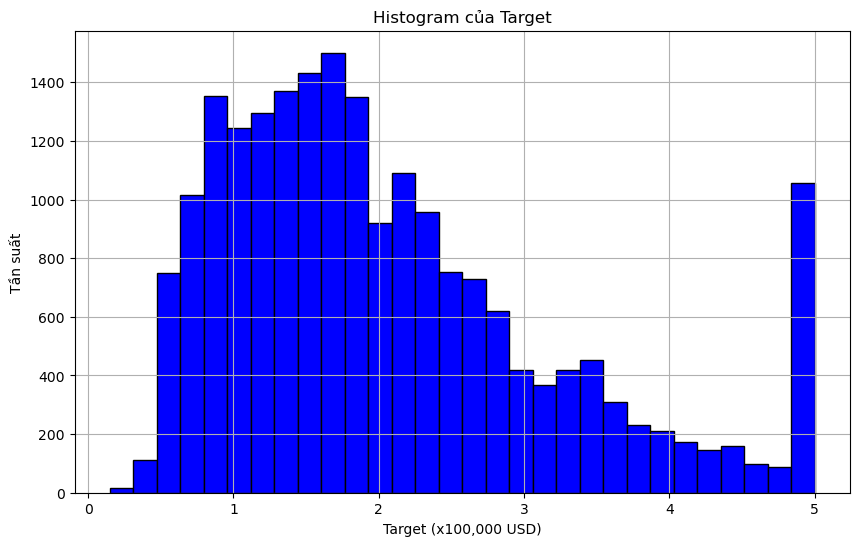

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(data['target'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram của Target')
plt.xlabel('Target (x100,000 USD)')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()

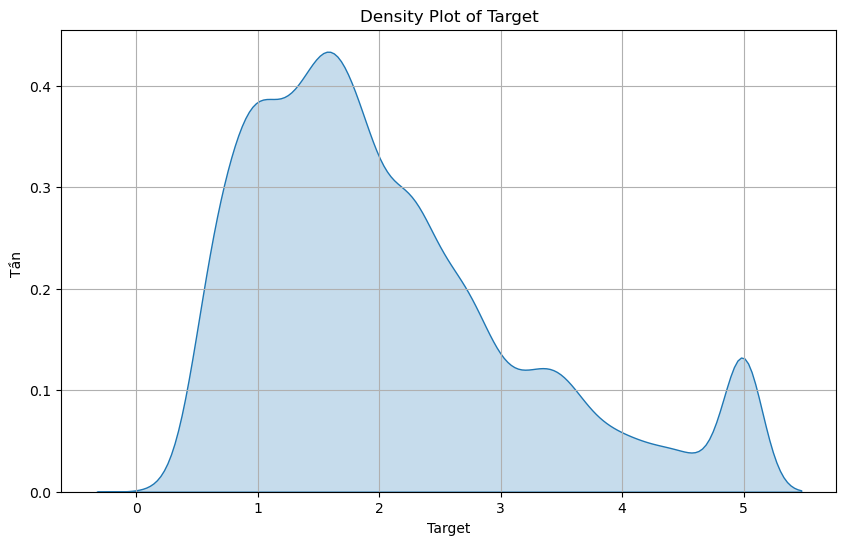

In [11]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data['target'], fill=True)
plt.title('Density Plot of Target')
plt.xlabel('Target')
plt.ylabel('Tần ')
plt.grid(True)
plt.show()

###### Mối quan hệ giữa thu nhập trung bình và giá nhà:

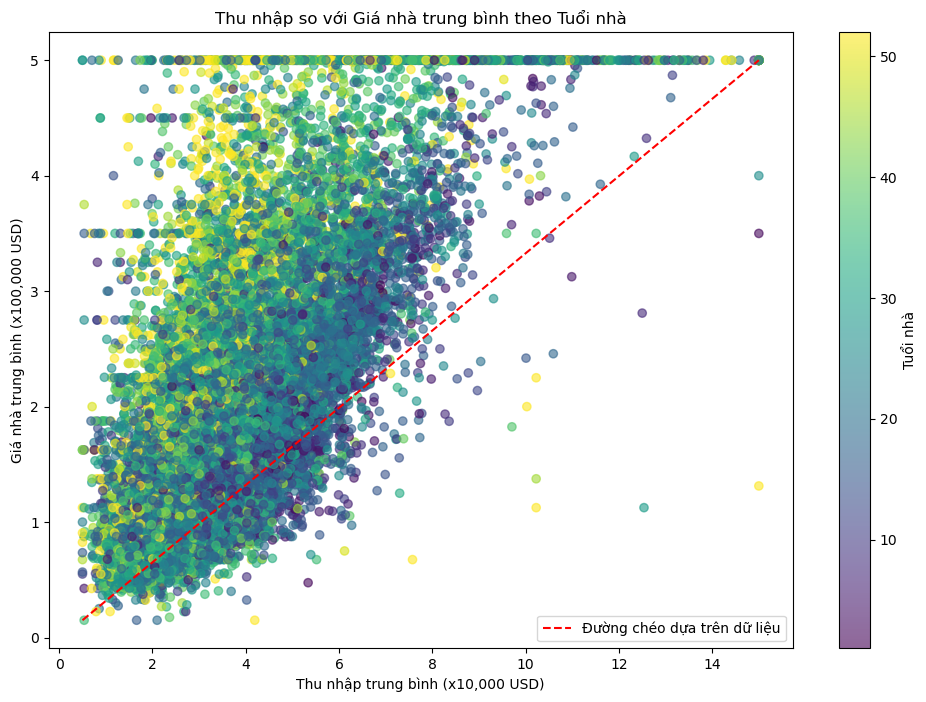

In [12]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['MedInc'], data['target'], alpha=0.6, c=data['HouseAge'], cmap='viridis')
plt.xlabel('Thu nhập trung bình (x10,000 USD)')
plt.ylabel('Giá nhà trung bình (x100,000 USD)')
plt.title('Thu nhập so với Giá nhà trung bình theo Tuổi nhà')
plt.colorbar(scatter, label='Tuổi nhà')

# Tìm giá trị min và max của trục x và y để đảm bảo đường chéo đi qua khoảng giá trị của dữ liệu
x_min, x_max = data['MedInc'].min(), data['MedInc'].max()
y_min, y_max = data['target'].min(), data['target'].max()

# Vẽ đường chéo từ điểm thấp nhất đến điểm cao nhất trong dữ liệu
plt.plot([x_min, x_max], [y_min, y_max], 'r--', label='Đường chéo dựa trên dữ liệu')

# Thêm legend để hiển thị thông tin của đường chéo
plt.legend()

plt.show()

###### Bản đồ phân tán dựa trên mật độ người, thu nhập trung bình, kinh độ và vĩ độ:

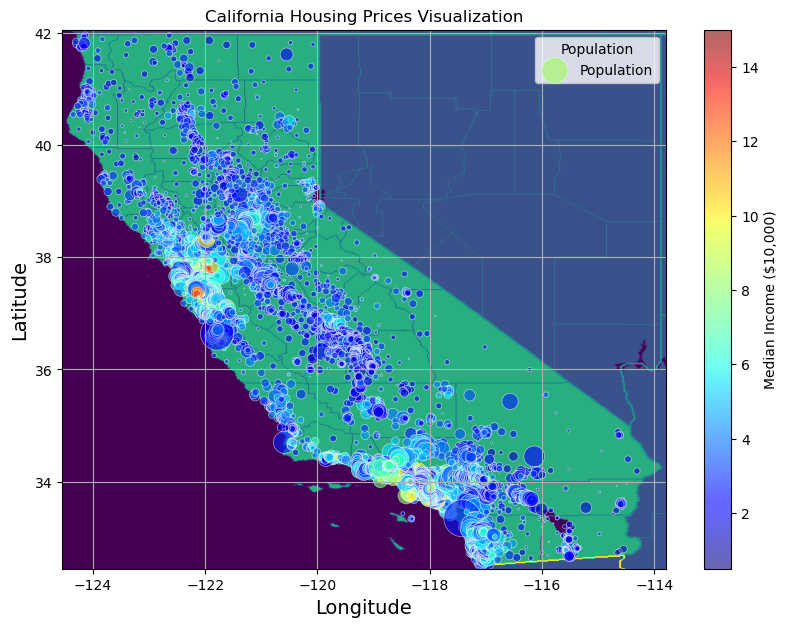

In [13]:
# Tạo biểu đồ phân tán, chỉnh sửa các tham số cho dễ nhìn
plt.figure(figsize=(10, 7))
sc = plt.scatter(data['Longitude'], data['Latitude'], alpha=0.6,
                 s=data['Population'] / 50,  # Giảm kích thước chấm để tránh quá lớn
                 label='Population', c=data['MedInc'],
                 cmap=plt.get_cmap('jet'), edgecolors='w', linewidths=0.5)

# Thêm hình ảnh bản đồ California làm nền
# giới hạn trái và phải - kinh độ (-124.55, -113.80) và vĩ độ (32.45, 42.05)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05])

plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.colorbar(sc, label='Median Income ($10,000)')  # Thêm color bar để thể hiện thông tin thu nhập trung bình
plt.legend(title='Population')
plt.title("California Housing Prices Visualization")
plt.grid(True)  # Thêm lưới cho dễ nhìn

plt.show()

In [14]:
# Tải dữ liệu GeoJSON
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson'
response = requests.get(url)
geo_data = response.json()

# Tạo DataFrame cho tọa độ trung tâm của mỗi khu vực từ GeoJSON
regions = []
for feature in geo_data['features']:
    geom = shape(feature['geometry'])
    centroid = geom.centroid
    regions.append({
        'name': feature['properties']['name'],
        'latitude': centroid.y,
        'longitude': centroid.x
    })
regions_df = pd.DataFrame(regions)

# Tạo KDTree
tree = KDTree(regions_df[['longitude', 'latitude']])

# Giả sử `data` là DataFrame của bạn đã có các cột Longitude và Latitude
# Query để tìm khu vực gần nhất cho mỗi điểm dữ liệu
distances, indices = tree.query(data[['Longitude', 'Latitude']], k=1)

# Gán tên khu vực
data['Region'] = regions_df.iloc[indices.flatten()]['name'].values

# Tính giá trung bình theo khu vực
avg_price_per_region = data.groupby('Region')['target'].mean().reset_index()

# Tạo bản đồ
sf_map = folium.Map(location=[37.5, -119.5], zoom_start=6)

# Thêm Choropleth layer
folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=avg_price_per_region,
    columns=['Region', 'target'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average House Price'
).add_to(sf_map)

# Hiển thị bản đồ
sf_map

###### Biểu đồ tương ứng của từng đặc trưng

array([[<Axes: xlabel='MedInc', ylabel='MedInc'>,
        <Axes: xlabel='HouseAge', ylabel='MedInc'>,
        <Axes: xlabel='AveRooms', ylabel='MedInc'>,
        <Axes: xlabel='AveBedrms', ylabel='MedInc'>,
        <Axes: xlabel='Population', ylabel='MedInc'>,
        <Axes: xlabel='AveOccup', ylabel='MedInc'>,
        <Axes: xlabel='Latitude', ylabel='MedInc'>,
        <Axes: xlabel='Longitude', ylabel='MedInc'>,
        <Axes: xlabel='target', ylabel='MedInc'>],
       [<Axes: xlabel='MedInc', ylabel='HouseAge'>,
        <Axes: xlabel='HouseAge', ylabel='HouseAge'>,
        <Axes: xlabel='AveRooms', ylabel='HouseAge'>,
        <Axes: xlabel='AveBedrms', ylabel='HouseAge'>,
        <Axes: xlabel='Population', ylabel='HouseAge'>,
        <Axes: xlabel='AveOccup', ylabel='HouseAge'>,
        <Axes: xlabel='Latitude', ylabel='HouseAge'>,
        <Axes: xlabel='Longitude', ylabel='HouseAge'>,
        <Axes: xlabel='target', ylabel='HouseAge'>],
       [<Axes: xlabel='MedInc', ylabel='AveR

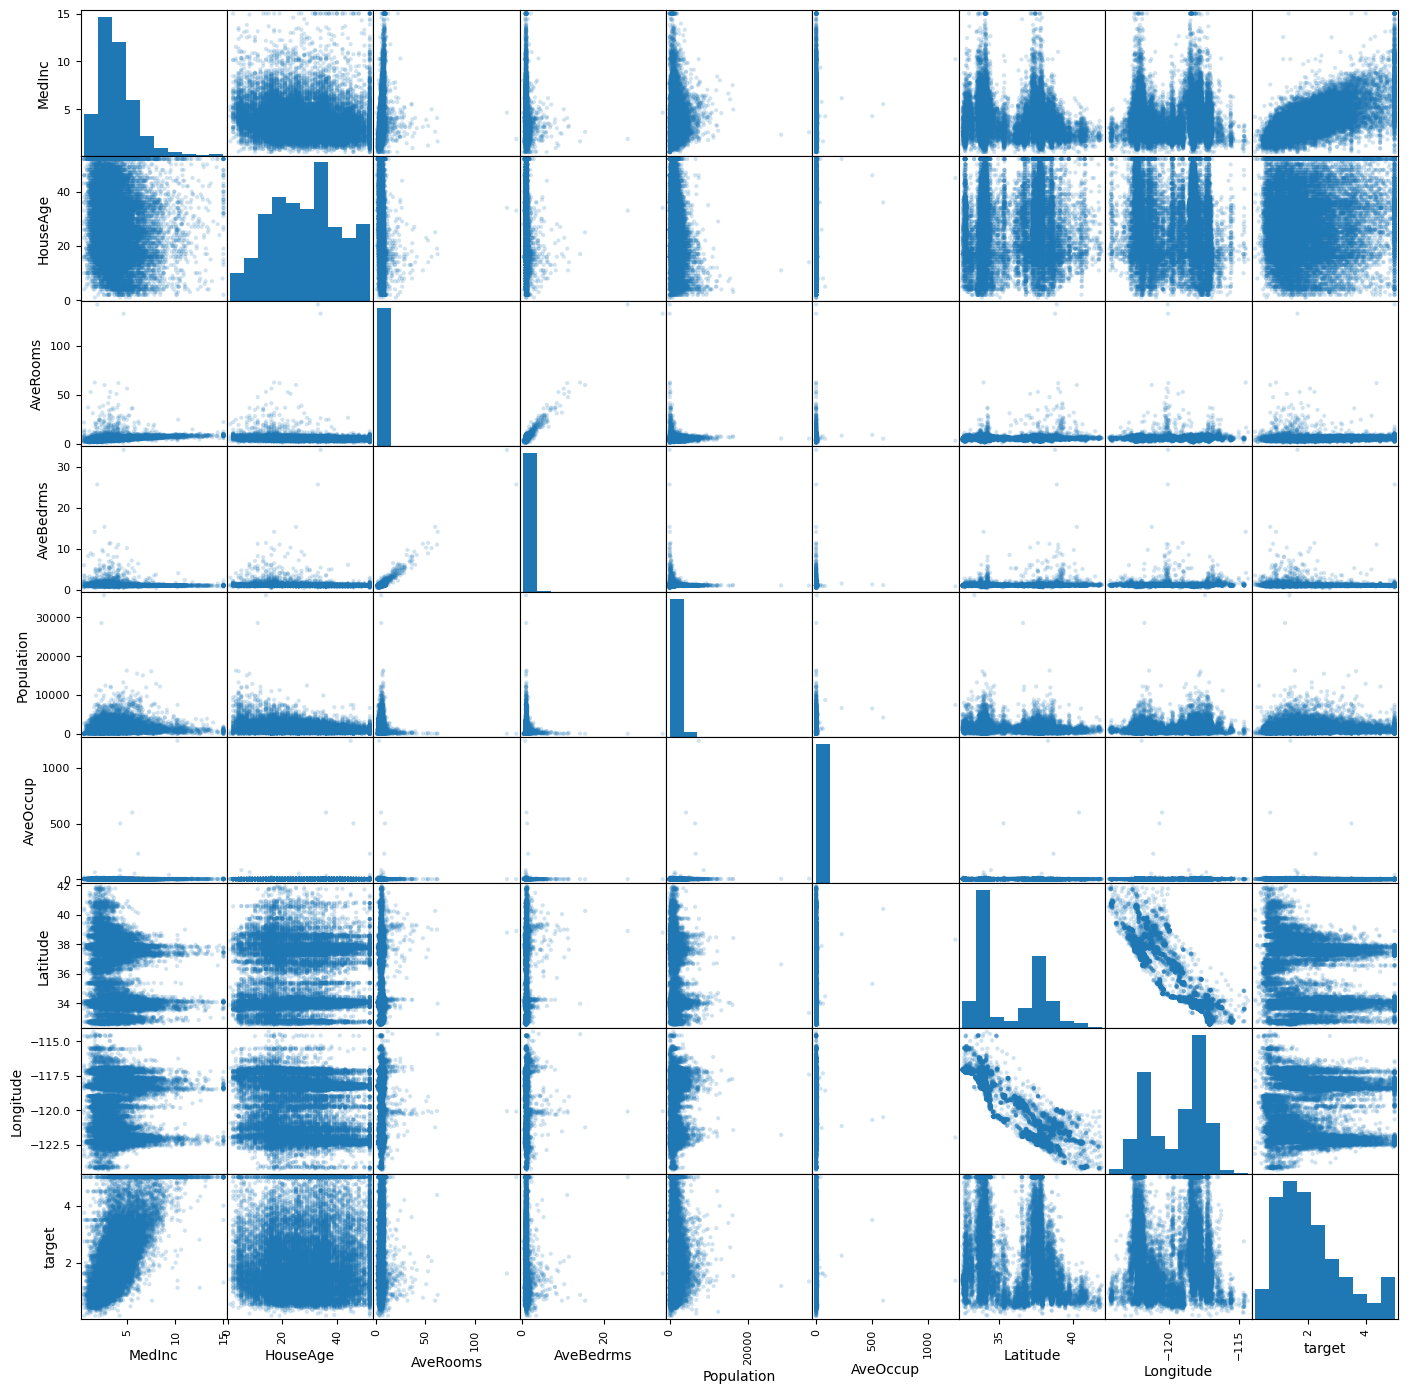

In [15]:
# data.hist(bins=50, figsize=(20,15))
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(17, 17), diagonal='hist')

In [16]:
data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target,Region
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,San Francisco
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,San Francisco
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,San Francisco
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,San Francisco
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,San Francisco
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697,San Francisco
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992,San Francisco
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414,San Francisco
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267,San Francisco
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611,San Francisco


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
 9   Region      20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


##### Xử lý Region

In [18]:
# Tạo các đối tượng LabelEncoder riêng biệt cho mỗi cột
region_encoder = LabelEncoder()

# Fit và transform cho mỗi cột
data['Region'] = region_encoder.fit_transform(data['Region'])

# Hiển thị các lớp đã được mã hóa

print("\nClasses mapped for Region:", region_encoder.classes_)
print("\n=> Sau khi đã xử lý: ", data['Region'].unique())

# Lưu cột 'target' vào cuối DataFrame
target = data['target']
data.drop(columns='target', inplace=True)
data['target'] = target


Classes mapped for Region: ['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'
 'Placer' 'Plumas' 'Riverside' 'Sacramento' 'San Benito' 'San Bernardino'
 'San Diego' 'San Francisco' 'San Joaquin' 'San Luis Obispo' 'San Mateo'
 'Santa Barbara' 'Santa Clara' 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou'
 'Solano' 'Sonoma' 'Stanislaus' 'Sutter' 'Tehama' 'Trinity' 'Tulare'
 'Tuolumne' 'Ventura' 'Yolo' 'Yuba']

=> Sau khi đã xử lý:  [37  6  0  1  2  8  3 57 50  4  5 38  7 30 33  9 19 53 15 23 34 10 11 12
 32 25 13 35 14 55 41 18 16 27 48 24 17 31 45 29 20 21 22 49 43 42 26 39
 47 28 36 56 40 44 51 52 46 54]


###### Tính toán Ma trận Tương Quan và Trực Quan Hóa

target        1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
Region        0.062691
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: target, dtype: float64


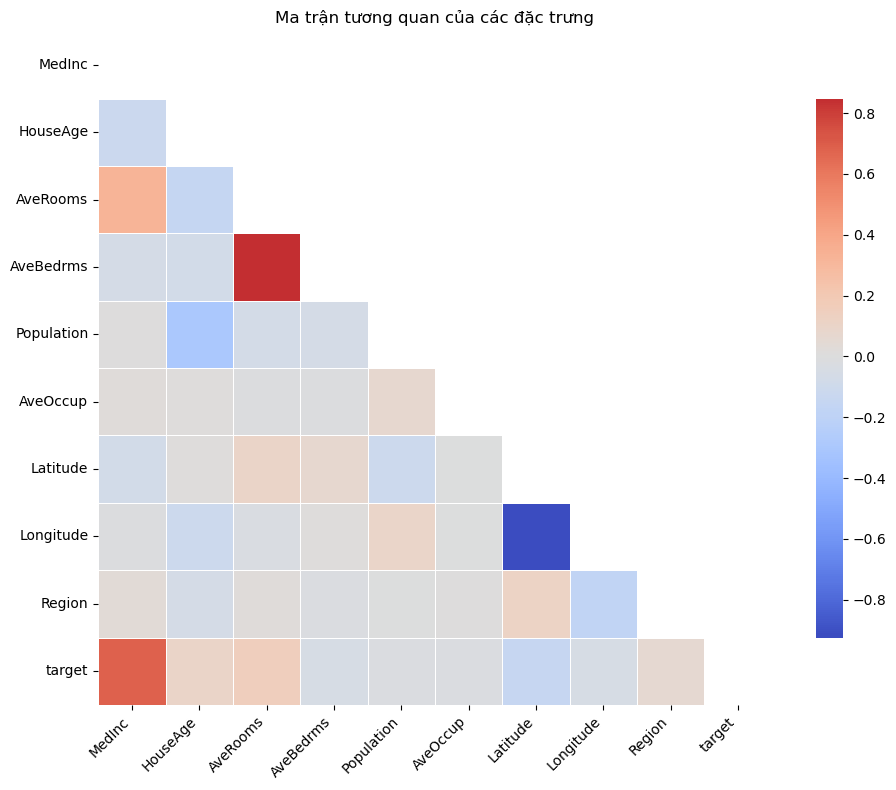

In [19]:
# Tính ma trận tương quan
correlation_matrix = data.corr()
print(correlation_matrix['target'].sort_values(ascending=False))

# Tạo mask cho nửa trên của ma trận
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Tạo bản đồ nhiệt chỉ hiển thị nửa dưới
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
                      square=True, linewidths=.5, cbar_kws={'shrink': .8}, center=0,
                      annot_kws={"size": 10}, linecolor='white')

plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X để tránh chồng chéo
plt.yticks(rotation=0)  # Đảm bảo nhãn trục Y đứng thẳng
plt.title('Ma trận tương quan của các đặc trưng')
plt.tight_layout()  # Tự động điều chỉnh subplot để nó vừa vặn với khu vực hiển thị
plt.show()

###### Chia dữ liệu thành tập huấn luyện (train 80%) và kiểm tra (test 20%)

In [20]:
# Chỉ định các cột cho X và y
X = data.drop(['target','AveBedrms','Population'], axis=1)
y = data['target']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train

,MedInc,HouseAge,AveRooms,AveOccup,Latitude,Longitude,Region
14196,3.2596,33.0,5.017657,3.691814,32.71,-117.03,36
8267,3.8125,49.0,4.473545,1.738095,33.77,-118.16,29
17445,4.1563,4.0,5.645833,2.723214,34.66,-120.48,41
14265,1.9425,36.0,4.002817,3.994366,32.69,-117.11,36
2271,3.5542,43.0,6.268421,2.300000,36.78,-119.80,9
...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,3.032258,33.78,-117.96,29
11964,3.0500,33.0,6.868597,3.904232,34.02,-117.43,29
5390,2.9344,36.0,3.986717,3.332068,34.03,-118.38,18
860,5.7192,15.0,6.395349,3.178891,37.58,-121.96,0


In [22]:
X_test

,MedInc,HouseAge,AveRooms,AveOccup,Latitude,Longitude,Region
20046,1.6812,25.0,4.192201,3.877437,36.06,-119.01,53
3024,2.5313,30.0,5.039384,2.679795,35.14,-119.46,41
15663,3.4801,52.0,3.977155,1.360332,37.80,-122.44,37
20484,5.7376,17.0,6.163636,3.444444,34.28,-118.72,55
9814,3.7250,34.0,5.492991,2.483645,36.62,-121.93,43
...,...,...,...,...,...,...,...
15362,4.6050,16.0,7.002212,2.988938,33.36,-117.22,36
16623,2.7266,28.0,6.131915,2.340426,35.36,-120.83,39
18086,9.2298,25.0,7.237676,2.790493,37.31,-122.05,43
2144,2.7850,36.0,5.289030,2.588608,36.77,-119.76,9


In [23]:
y_train

14196    1.030
8267     3.821
17445    1.726
14265    0.934
2271     0.965
         ...  
11284    2.292
11964    0.978
5390     2.221
860      2.835
15795    3.250
Name: target, Length: 16512, dtype: float64

In [24]:
y_test

20046    0.47700
3024     0.45800
15663    5.00001
20484    2.18600
9814     2.78000
          ...   
15362    2.63300
16623    2.66800
18086    5.00001
2144     0.72300
3665     1.51500
Name: target, Length: 4128, dtype: float64

#### Chuẩn hóa dữ liệu

In [25]:
# Scaling - Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Huấn luyện scaler và biến đổi dữ liệu huấn luyện
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)  # Convert back to DataFrame and add column names
X_test_scaled = scaler.transform(X_test)  # Áp dụng scaler đã huấn luyện cho dữ liệu kiểm tra

In [26]:
X_train_scaled.head(30)

,MedInc,HouseAge,AveRooms,AveOccup,Latitude,Longitude,Region
0,-0.326196,0.348490,-0.174916,0.051376,-1.372811,1.272587,0.621108
1,-0.035843,1.618118,-0.402835,-0.117362,-0.876696,0.709162,0.077404
2,0.144701,-1.952710,0.088216,-0.032280,-0.460146,-0.447603,1.009468
3,-1.017864,0.586545,-0.600015,0.077507,-1.382172,1.232698,0.621108
4,-0.171488,1.142008,0.349007,-0.068832,0.532084,-0.108551,-1.476036
5,1.439919,-0.683082,0.354757,0.023111,0.831625,-1.135679,-2.175084
6,-0.715013,-0.048268,-0.456530,0.034142,-0.750327,0.803897,-0.776988
7,2.157529,0.665897,0.258670,-0.060568,1.060961,-1.469745,0.698780
8,-1.250241,-1.873359,-0.760128,-0.040033,-0.708204,0.838800,-0.776988
9,1.336938,-1.873359,0.542474,0.025712,-0.759688,0.893646,0.077404


In [27]:
X_test_scaled

array([[-1.15508475, -0.28632369, -0.52068576, ...,  0.1951    ,
         0.28534728,  1.94153166],
       [-0.70865905,  0.11043502, -0.16581537, ..., -0.23549054,
         0.06097472,  1.00946776],
       [-0.21040155,  1.85617335, -0.61076476, ...,  1.00947776,
        -1.42487026,  0.6987798 ],
       ...,
       [ 2.80902421, -0.28632369,  0.75501156, ...,  0.78014149,
        -1.23041404,  1.16481175],
       [-0.57542978,  0.58654547, -0.06124296, ...,  0.52740357,
        -0.08860699, -1.47603596],
       [-0.17259111, -0.92113763, -0.6058703 , ..., -0.66608108,
         0.60445493, -0.77698804]])

# Bước 3: Train the model

##### Khởi tạo và huấn luyện mô hình Linear Regression

In [28]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

##### Khởi tạo và huấn luyện mô hình Random Forest

In [29]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train.values.ravel())

RandomForestRegressor(random_state=42)

##### Áp dụng GridSearchCV vào mô hình Random Forest để tinh chỉnh các tham số và tìm ra cấu hình tốt nhất

In [30]:
# # Định nghĩa lưới tham số cho Random Forest
# param_grid = {
#     'n_estimators': [100, 200],  # Số lượng cây
#     'max_features': ['auto', 'sqrt'],  # Số lượng đặc trưng để xem xét tại mỗi phân chia
#     'max_depth': [None, 10, 20],  # Độ sâu tối đa của cây
#     'min_samples_split': [2, 5],  # Số lượng mẫu tối thiểu cần thiết để phân chia một nút
#     'min_samples_leaf': [1, 2]  # Số lượng mẫu tối thiểu tại mỗi lá
# }

##############################
# Sử dụng các tham số tốt nhất tìm được để khởi tạo mô hình RandomForestRegressor mới để tiết kiệm thời gian train
param_grid = {
    'n_estimators': [200],  # Số lượng cây
    'max_features': ['sqrt'],  # Số lượng đặc trưng để xem xét tại mỗi phân chia
    'max_depth': [None],  # Độ sâu tối đa của cây
    'min_samples_split': [2],  # Số lượng mẫu tối thiểu cần thiết để phân chia một nút
    'min_samples_leaf': [1]  # Số lượng mẫu tối thiểu tại mỗi lá
}
##############################

# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(random_state=42)

# Cross-validation - Sử dụng GridSearchCV để tìm tham số tốt nhất và thực hiện cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='neg_mean_squared_error', n_jobs=-1)

# Huấn luyện GridSearchCV với dữ liệu huấn luyện đã chuẩn hóa
grid_search.fit(X_train_scaled, y_train.values.ravel())

# In tham số tốt nhất tìm được
print("Best parameters:", grid_search.best_params_)

# Sử dụng mô hình tối ưu hóa
best_rf_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


##### Khởi tạo và huấn luyện mô hình Gradient Boosting Regressor

In [31]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_scaled, y_train.values.ravel())

GradientBoostingRegressor(random_state=42)

# Bước 4: Evaluate the model

##### Dự đoán và đánh giá 4 mô hình

In [32]:
predictions = {
    "Linear Regression": lr_model.predict(X_test_scaled),
    "Random Forest": rf_model.predict(X_test_scaled),
    "Gradient Boosting": gb_model.predict(X_test_scaled),
    "Tuned Random Forest": best_rf_model.predict(X_test_scaled)
}

##### Phân tích sai số và trực quan hóa kết quả


- - - - - - - - - - - - - - - - - - - - - PHÂN TÍCH SAI SỐ VÀ TRỰC QUAN HÓA KẾT QUẢ - - - - - - - - - - - - - - - - - - - - - 


 - MÔ HÌNH 1: Linear Regression
 - MSE: 0.55
 - RMSE: 0.7397668062512824
 - R2: 0.58


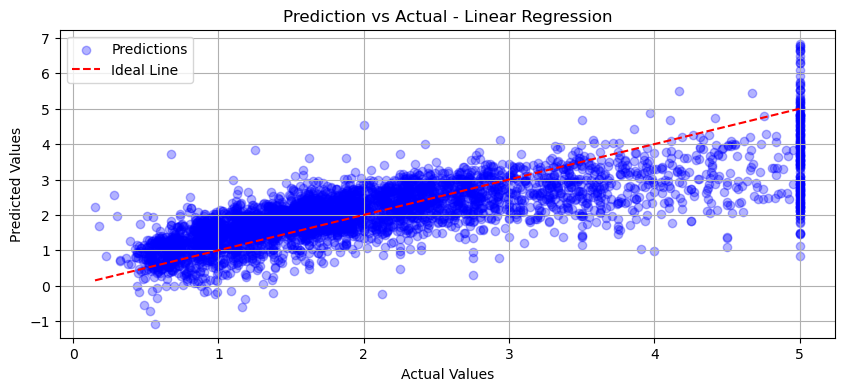


 - MÔ HÌNH 2: Random Forest
 - MSE: 0.24
 - RMSE: 0.49480556058431313
 - R2: 0.81


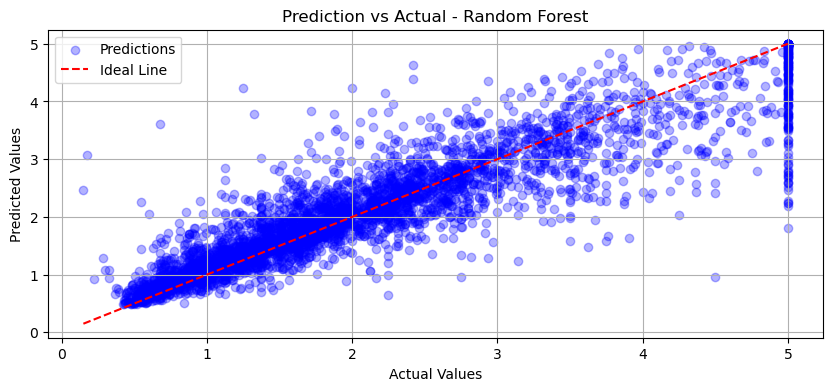


 - MÔ HÌNH 3: Gradient Boosting
 - MSE: 0.29
 - RMSE: 0.5359149597691046
 - R2: 0.78


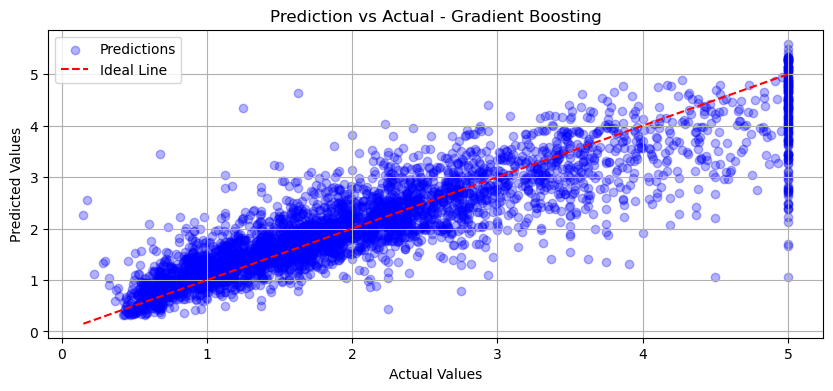


 - MÔ HÌNH 4: Tuned Random Forest
 - MSE: 0.22
 - RMSE: 0.4678062084288439
 - R2: 0.83


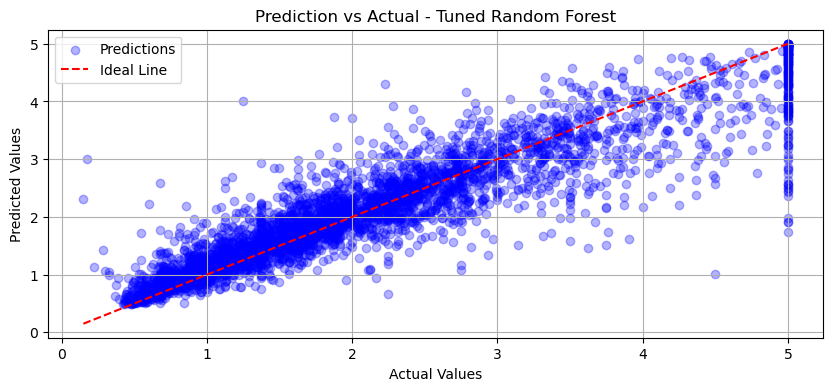

In [33]:
# Phân tích sai số và trực quan hóa kết quả
print("\n- - - - - - - - - - - - - - - - - - - - - PHÂN TÍCH SAI SỐ VÀ TRỰC QUAN HÓA KẾT QUẢ - - - - - - - - - - - - - - - - - - - - - \n")
i=1
name_models = []
mse_models = []
rmse_models = []
r2_models = []
for name, pred in predictions.items():    
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)
    print(f"\n - MÔ HÌNH {i}: {name}\n - MSE: {mse:.2f}\n - RMSE: {rmse}\n - R2: {r2:.2f}")
    name_models.append(name)
    mse_models.append(mse)
    rmse_models.append(rmse)
    r2_models.append(r2)
    
    i = i + 1
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, pred, alpha=0.3, label='Predictions', color='b', marker='o')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Line')
    plt.title(f"Prediction vs Actual - {name}")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.legend()
    plt.show()

##### Tìm mô hình tốt nhất qua các chỉ số tốt nhất: MSE thấp nhất, RMSE thấp nhất, R2 cao nhất

In [34]:
print("\n\n= = = = = = = = = = = = = = = TỔNG HỢP - SO SÁNH = = = = = = = = = = = = = = =\n")

# Tìm chỉ số tốt nhất: MSE thấp nhất, RMSE thấp nhất, R2 cao nhất
best_mse_idx = np.argmin(mse_models)
best_rmse_idx = np.argmin(rmse_models)
best_r2_idx = np.argmax(r2_models)

print("""

Mô Hình: {0}

MSE Score: {1}

RMSE Score: {2}

R2 Score: {3}

------------------------------------- 
""".format(name_models,  
           mse_models,     
           rmse_models, 
           r2_models))

# Đưa ra mô hình tốt nhất dựa trên từng chỉ số
print(f"Best model based on MSE: {name_models[best_mse_idx]} (MSE = {mse_models[best_mse_idx]})")
print(f"Best model based on RMSE: {name_models[best_rmse_idx]} (RMSE = {rmse_models[best_rmse_idx]})")
print(f"Best model based on R2 Score: {name_models[best_r2_idx]} (R2 = {r2_models[best_r2_idx]})")

# Xác định mô hình tốt nhất dựa trên sự đồng thuận
scores = [0] * len(name_models)
scores[best_mse_idx] += 1
scores[best_rmse_idx] += 1
scores[best_r2_idx] += 1

# Tìm mô hình với điểm số cao nhất
best_model_index = np.argmax(scores)
print(f"\n => Overall best model for datase California Housing: {name_models[best_model_index]} !!!")



= = = = = = = = = = = = = = = TỔNG HỢP - SO SÁNH = = = = = = = = = = = = = = =



Mô Hình: ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Tuned Random Forest']

MSE Score: [0.5472549276312225, 0.24483254278515637, 0.28720484410432107, 0.21884264864457095]

RMSE Score: [0.7397668062512824, 0.49480556058431313, 0.5359149597691046, 0.4678062084288439]

R2 Score: [0.5823785270718607, 0.81316325906602, 0.7808280858317481, 0.8329966809763876]

------------------------------------- 

Best model based on MSE: Tuned Random Forest (MSE = 0.21884264864457095)
Best model based on RMSE: Tuned Random Forest (RMSE = 0.4678062084288439)
Best model based on R2 Score: Tuned Random Forest (R2 = 0.8329966809763876)

 => Overall best model for datase California Housing: Tuned Random Forest !!!


##### Đánh giá mô hình TURNED RANDOM FOREST trên dữ liệu huấn luyện và kiểm thử

In [35]:
# Dự đoán trên tập huấn luyện
train_preds = best_rf_model .predict(X_train_scaled)
# Dự đoán trên tập kiểm thử
test_preds = best_rf_model .predict(X_test_scaled)

# Đánh giá mô hình trên tập huấn luyện
train_mse = mean_squared_error(y_train, train_preds)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, train_preds)

# Đánh giá mô hình trên tập kiểm thử
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_preds)

print(f"Train MSE: {train_mse:.2f}, Train RMSE: {train_rmse:.2f}, Train R2: {train_r2:.2f}")
print(f"\nTest MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R2: {test_r2:.2f}")

Train MSE: 0.03, Train RMSE: 0.17, Train R2: 0.98

Test MSE: 0.22, Test RMSE: 0.47, Test R2: 0.83


##### Lấy ra mức độ quan trọng của từng đặc trưng [RANDOM FOREST]

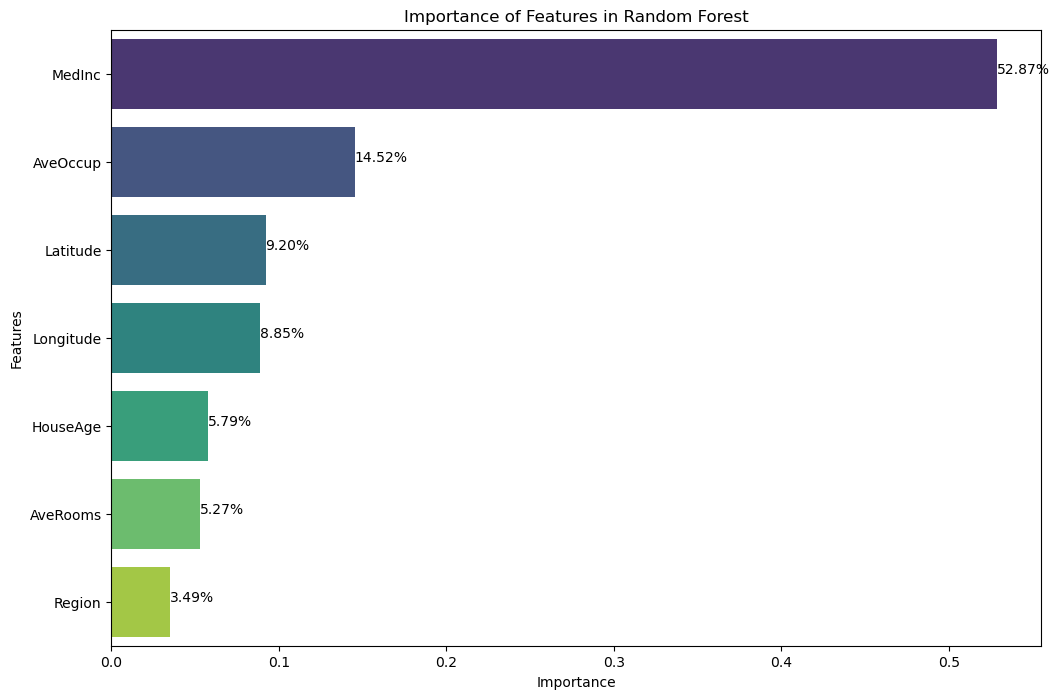

In [36]:
# Lấy ra mức độ quan trọng của từng đặc trưng với mô hình Random  
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="viridis")

# Add values on each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



##### Lấy ra mức độ quan trọng của từng đặc trưng [TURNED RANDOM FOREST]

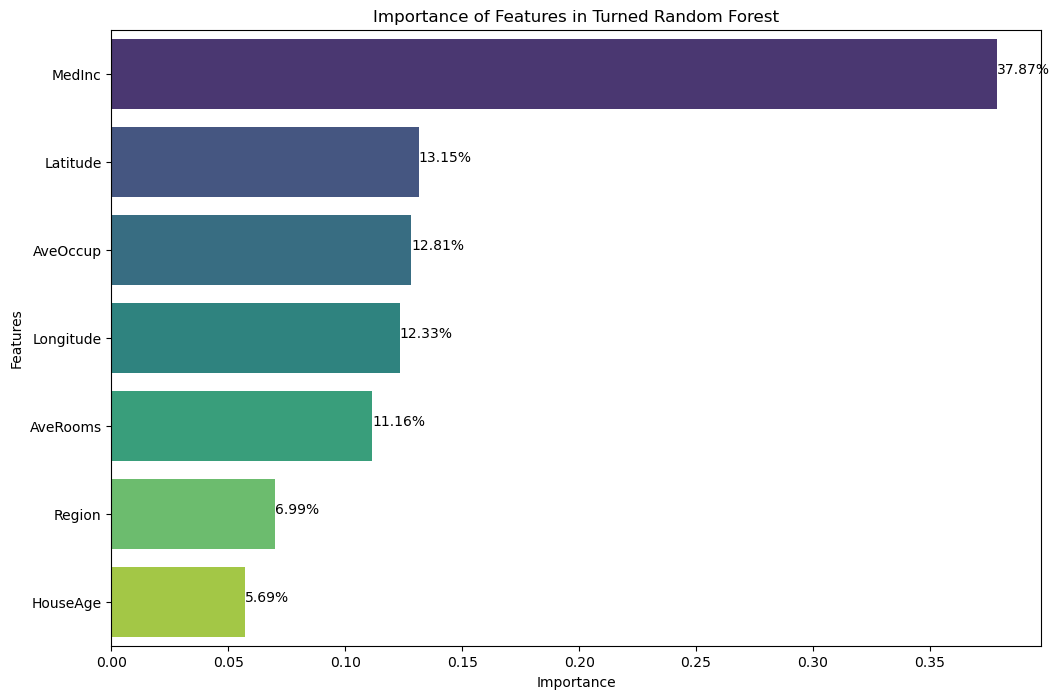

In [37]:
# Lấy ra mức độ quan trọng của từng đặc trưng với mô hình Turned Random  
feature_importances = pd.DataFrame(best_rf_model.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa

plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x=feature_importances['importance'], y=feature_importances.index, palette="viridis")

# Add values on each bar
for index, value in enumerate(feature_importances['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features in Turned Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



##### Lấy ra mức độ quan trọng của từng đặc trưng [GRADIENT BOOSTING REGRESSOR]

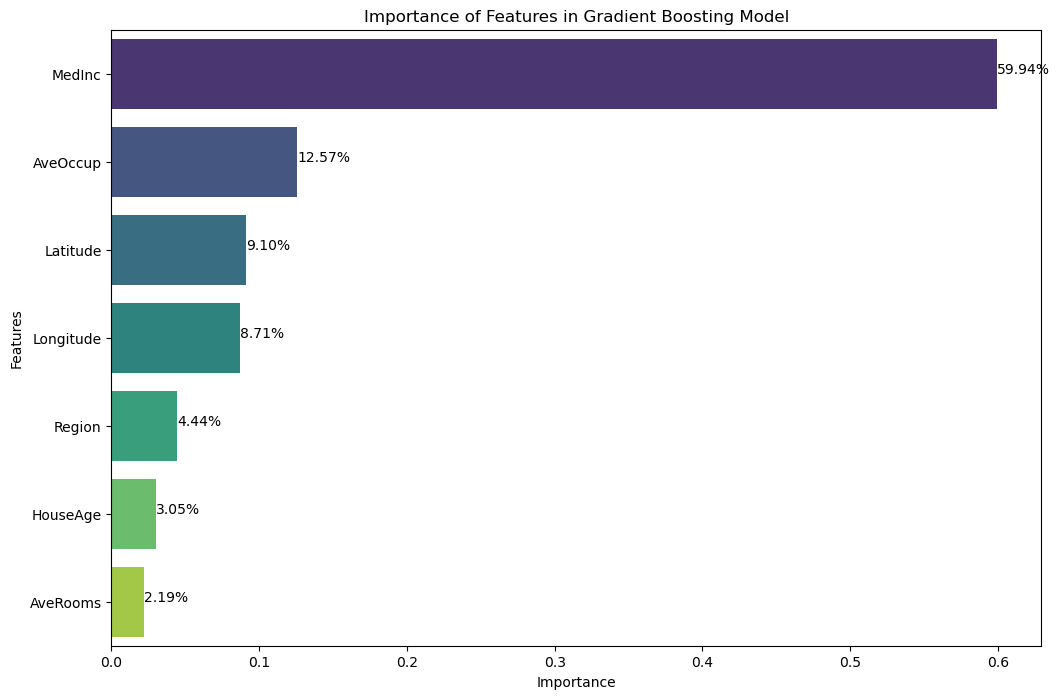

In [38]:
# Trích xuất tầm quan trọng của các đặc trưng
feature_importances_gb = pd.DataFrame(gb_model.feature_importances_,
                                      index = X.columns,
                                      columns=['importance']).sort_values('importance', ascending=False)

# Trực quan hóa tầm quan trọng của các đặc trưng
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_gb['importance'], y=feature_importances_gb.index, palette="viridis")

# Thêm giá trị vào từng thanh (tùy chọn)
for index, value in enumerate(feature_importances_gb['importance']):
    plt.text(value, index, f"{value*100:.2f}%")

plt.title('Importance of Features in Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

##### Trích xuất và hiển thị hệ số trong Linear Regression

Với mô hình Linear Regression, việc xác định "tầm quan trọng" của các đặc trưng không giống như với các mô hình dựa trên cây như Random Forest hoặc Gradient Boosting. Thay vào đó, trong Linear Regression, tầm quan trọng của đặc trưng thường được đánh giá qua hệ số (coefficients) của chúng. Hệ số này cho biết mối liên hệ giữa mỗi đặc trưng độc lập và biến mục tiêu, cũng như mức độ ảnh hưởng của đặc trưng đó đối với biến mục tiêu khi tất cả các đặc trưng khác được giữ cố định.

Hệ số (Coefficient): Mỗi hệ số cho biết mức độ thay đổi trung bình dự kiến trong biến mục tiêu (ví dụ, giá nhà) cho một đơn vị thay đổi của đặc trưng tương ứng, giữ nguyên các đặc trưng khác. Nếu hệ số là dương, giá trị của biến mục tiêu sẽ tăng khi đặc trưng tăng; nếu hệ số là âm, giá trị của biến mục tiêu sẽ giảm.

Dương (+): Nếu hệ số là dương, điều đó có nghĩa là có một mối quan hệ dương giữa đặc trưng và giá nhà. Ví dụ, nếu hệ số cho "MedInc" (thu nhập trung bình) là dương, điều đó có nghĩa là càng có thu nhập cao, giá nhà càng cao.

Âm (-): Nếu hệ số là âm, có một mối quan hệ nghịch giữa đặc trưng và giá nhà. Ví dụ, nếu hệ số cho "Population" là âm, điều đó có thể cho thấy rằng khu vực đông dân có thể có giá nhà thấp hơn.

Giá trị tuyệt đối của hệ số: Kích thước của hệ số cho biết mức độ mạnh của ảnh hưởng. Một hệ số lớn (dù dương hay âm) có nghĩa là đặc trưng đó có ảnh hưởng đáng kể đến giá nhà.

Ví dụ: Giả sử chúng ta có một hệ số cho "MedInc" là 0.8, điều này có nghĩa là với mỗi đơn vị tăng của thu nhập trung bình (ví dụ, 10,000 USD), giá nhà trung bình dự kiến tăng thêm 80,000 USD, giữ nguyên các yếu tố khác.

Đặc trưng với thanh dài nhất (dù dương hay âm) là đặc trưng có ảnh hưởng lớn nhất.



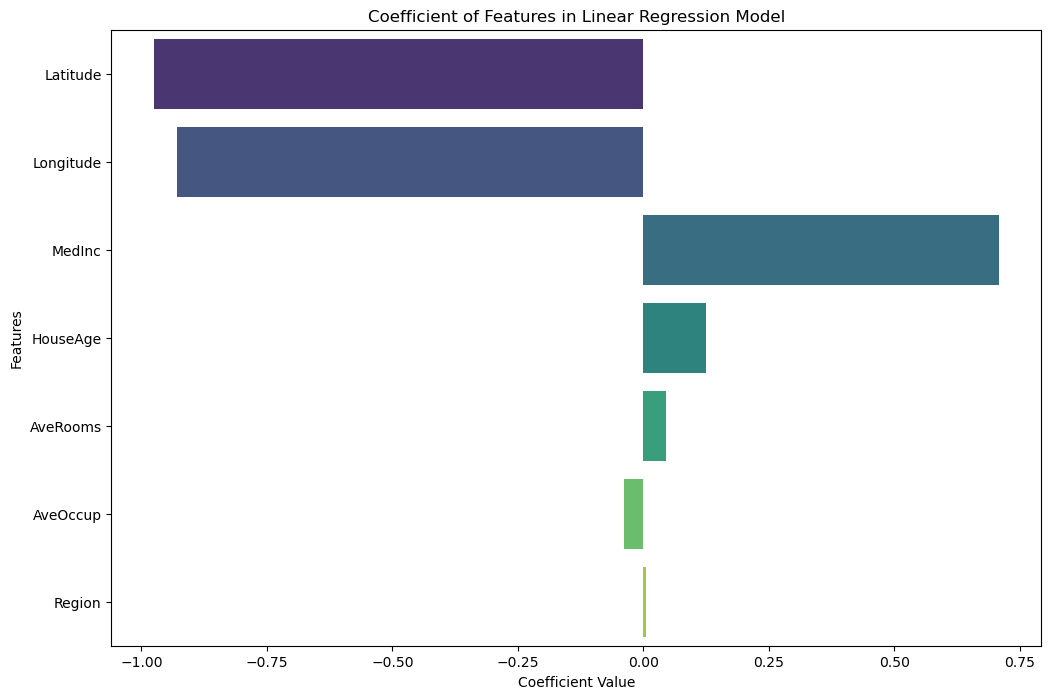

In [39]:
# Trích xuất hệ số của các đặc trưng
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_.flatten()  # Sử dụng flatten() để chuyển ma trận hệ số thành vector
})

# Sắp xếp các hệ số theo giá trị tuyệt đối để xem đặc trưng nào có ảnh hưởng lớn nhất
coefficients = coefficients.sort_values(by='Coefficient', key=abs, ascending=False)

# Trực quan hóa hệ số của các đặc trưng
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="viridis")
plt.title('Coefficient of Features in Linear Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


# Bước 5: Use the model

In [40]:
# Chọn ngẫu nhiên 15 chỉ số từ X_test_scaled
np.random.seed(5)
random_indices = np.random.choice(X_test_scaled.shape[0], size=15, replace=False)

# Lấy mẫu dữ liệu từ X_test và X_test_scaled dùng các chỉ số ngẫu nhiên
random_samples = X_test.iloc[random_indices]  # Lấy từ X_test không chuẩn hóa
random_samples_scaled = X_test_scaled[random_indices]  # Lấy từ X_test đã chuẩn hóa

# Dự đoán giá nhà cho các mẫu được chọn - TURNED RANDOM FOREST
predicted_prices = best_rf_model.predict(random_samples_scaled)

# Chuẩn bị DataFrame để hiển thị kết quả
results_df = random_samples.copy()  # Sao chép thông tin của các mẫu
results_df['Actual Price'] = y_test.iloc[random_indices].values * 100000  # Giá nhà thực tế
results_df['Predicted Price'] = predicted_prices * 100000  # Giá nhà dự đoán

# +: THỰC TẾ > DỰ ĐOÁN
# -: THỰC TẾ - DỰ ĐOÁN
# Tính tỷ lệ phần trăm cho Difference
results_df['Difference'] = (results_df['Actual Price'] - results_df['Predicted Price']) / results_df['Actual Price'] * 100


# Định dạng cột giá thành dạng tiền tệ USD
results_df['Actual Price'] = results_df['Actual Price'].apply(lambda x: f"${x:.2f}")
results_df['Predicted Price'] = results_df['Predicted Price'].apply(lambda x: f"${x:.2f}")
results_df['Difference'] = results_df['Difference'].apply(lambda x: "+100%" if x > 100 else ("-100%" if x < -100 else f"{x:.2f}%"))


# In kết quả chi tiết
results_df

,MedInc,HouseAge,AveRooms,AveOccup,Latitude,Longitude,Region,Actual Price,Predicted Price,Difference
4201,2.2167,39.0,3.447447,3.486486,34.11,-118.24,18,$176700.00,$175753.00,0.54%
7628,5.1440,27.0,5.041237,4.154639,33.85,-118.28,18,$180800.00,$203865.00,-12.76%
20141,2.7951,52.0,4.634868,3.226974,34.36,-119.06,55,$199300.00,$200465.51,-0.58%
19688,2.2431,41.0,4.799163,2.439331,39.13,-121.62,50,$63400.00,$78270.50,-23.46%
17041,6.1064,33.0,6.233818,2.615588,37.51,-122.28,40,$405000.00,$406688.07,-0.42%
3113,4.1500,11.0,5.500933,2.544776,35.62,-117.66,13,$85700.00,$94467.50,-10.23%
13504,2.3508,37.0,5.094139,3.650089,34.12,-117.32,29,$70500.00,$77990.00,-10.62%
18577,2.4375,20.0,4.790741,2.840741,36.93,-121.77,43,$190400.00,$186078.50,2.27%
7753,3.1369,19.0,4.129730,2.109459,33.91,-118.11,29,$196900.00,$194750.00,1.09%
6512,3.1042,37.0,4.508264,3.739669,34.07,-118.03,18,$152000.00,$170159.00,-11.95%


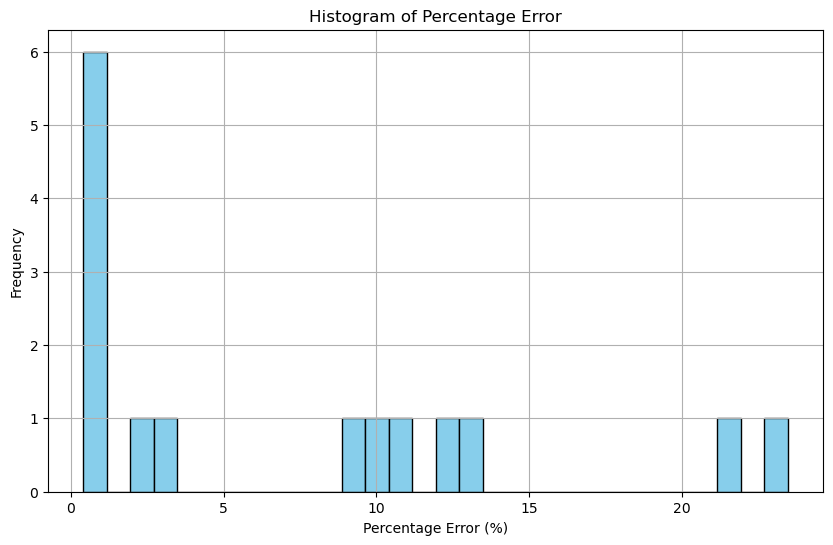

In [41]:
actual_prices = np.array([float(price.strip('$').replace(',', '')) for price in results_df['Actual Price']])
predicted_prices = np.array([float(price.strip('$').replace(',', '')) for price in results_df['Predicted Price']])

# Tính sai số tuyệt đối phần trăm
percentage_error = np.abs(predicted_prices - actual_prices) / actual_prices * 100

plt.figure(figsize=(10, 6))
plt.hist(percentage_error, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Percentage Error')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

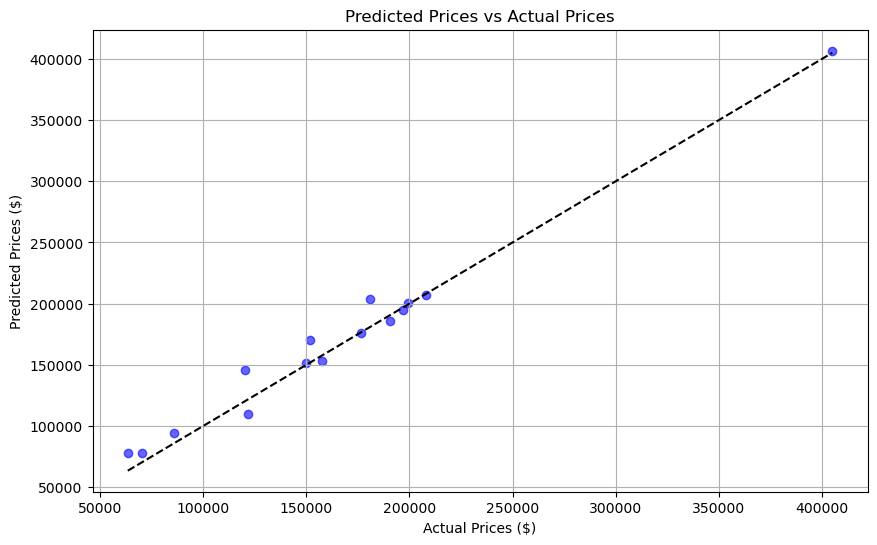

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, predicted_prices, alpha=0.6, c='blue')
plt.title('Predicted Prices vs Actual Prices')
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.plot([min(actual_prices), max(actual_prices)], [min(actual_prices), max(actual_prices)], 'k--') # Line showing perfect prediction
plt.grid(True)
plt.show()

In [43]:
# Giả sử predicted_prices là mảng chứa giá dự đoán từ mô hình, và actual_prices là giá thực tế
predicted_prices = best_rf_model.predict(X_test_scaled) * 100000  # Giả định dự đoán đã được scale lại như giá thực tế
actual_prices = y_test.values * 100000

# Tính sai số tuyệt đối phần trăm
percentage_error = np.abs(predicted_prices - actual_prices) / actual_prices * 100

# Định nghĩa ngưỡng là 20%
threshold = 20

# Tính tỉ lệ trúng
hits = np.sum(percentage_error <= threshold)
hit_rate = hits / len(percentage_error) * 100

# Tính tỉ lệ trượt
misses = np.sum(percentage_error > threshold)
miss_rate = misses / len(percentage_error) * 100

print(f"Hit Rate: {hit_rate:.2f}%")
print(f"Miss Rate: {miss_rate:.2f}%")

Hit Rate: 72.48%
Miss Rate: 27.52%


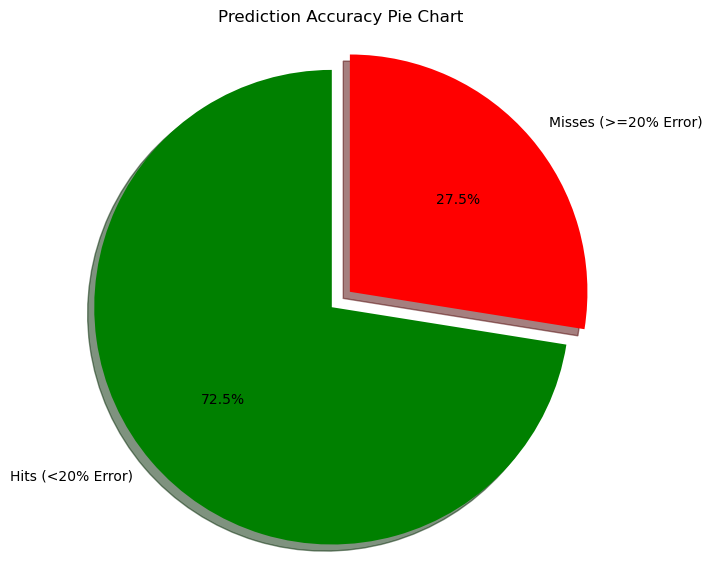

In [44]:
threshold = 20
hits = np.sum(percentage_error < threshold)
misses = np.sum(percentage_error >= threshold)

# Pie chart
sizes = [hits, misses]
labels = ['Hits (<20% Error)', 'Misses (>=20% Error)']
explode = (0.1, 0)

plt.figure(figsize=(7, 7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['green', 'red'])
plt.title('Prediction Accuracy Pie Chart')
plt.axis('equal')
plt.show()
